# **RECOMPRA EM E-COMMERCE: ADABOOST**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble                                   # AdaBoost
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV               # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [ ]:
dados_ecommerce = pd.read_table("Recompra_eCommerce.txt", sep = "\t")

### Visualização da base de dados

In [ ]:
display(dados_ecommerce)

ID_CLIENTE  IDADE  VALOR_COMPRA_SITE  QTDE_ITENS_COMPRA_SITE  \
0              1     29              185.5                       2   
1              2     27              215.5                       2   
2              3     29              106.4                       4   
3              4     18              140.2                       1   
4              5     24               72.9                       2   
...          ...    ...                ...                     ...   
1269        1270     40              165.9                       6   
1270        1271     33               55.6                       1   
1271        1272     28              105.7                       4   
1272        1273     28              284.9                       3   
1273        1274     32              351.4                       5   

      FLAG_ACESSORIOS_COMPRA_SITE  FLAG_FEMININA_COMPRA_SITE  \
0                               0                          1   
1                               0                          1   
2                               0                          1   
3                               0                          1   
4                               0                          1   
...                           ...                        ...   
1269                            0                          1   
1270                            0                          1   
1271                            0                          0   
1272                            0                          1   
1273                            1                          0   

      FLAG_MASCULINA_COMPRA_SITE  NOTA_SATISF_COMPRA_SITE  \
0                              0                        7   
1                              1                        7   
2                              0                       10   
3                              0                        8   
4                              0                        7   
...                          ...                      ...   
1269                           0                        8   
1270                           0                        9   
1271                           1                        6   
1272                           1                        8   
1273                           1                        8   

      FLAG_COMPROU_LOJA_FISICA_6M  QTDE_COMPRAS_LOJA_FISICA_6M  \
0                               1                            4   
1                               1                            2   
2                               1                            1   
3                               1                            1   
4                               0                            0   
...                           ...                          ...   
1269                            1                            3   
1270                            0                            0   
1271                            0                            0   
1272                            0                            0   
1273                            0                            0   

      QTDE_ITENS_LOJA_FISICA_6M  FLAG_RECOMPRA_PROX_3_MESES  
0                             4                           1  
1                             2                           1  
2                             5                           1  
3                             4                           0  
4                             0                           0  
...                         ...                         ...  
1269                          9                           1  
1270                          0                           0  
1271                          0                           0  
1272                          0                           0  
1273                          0                           1  

[1274 rows x 12 columns]

### Separação de features e target

In [ ]:
X = dados_ecommerce.drop(columns = ['FLAG_RECOMPRA_PROX_3_MESES', 'ID_CLIENTE'])
y = dados_ecommerce['FLAG_RECOMPRA_PROX_3_MESES']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
# Não necessário para esta base de dados, pois todas as variáveis explicativas são quantitativas

### Modelo 1: AdaBoost com otimização de hiperparâmetros via validação cruzada, com grid search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com grid search, com otimização de AUC e k = 10 (EXECUÇÃO ONEROSA)
adaboost = ensemble.AdaBoostClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(adaboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=AdaBoostClassifier(random_state=123),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'n_estimators': [10, 50, 100, 200]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'balanced_accuracy': 'balanced_accuracy',
                      'recall': 'recall'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'learning_rate': 0.5, 'n_estimators': 10}


In [ ]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

params  mean_test_AUC  std_test_AUC  \
12    {'learning_rate': 0.5, 'n_estimators': 10}       0.897374      0.022289   
7   {'learning_rate': 0.05, 'n_estimators': 200}       0.897188      0.024484   
10   {'learning_rate': 0.1, 'n_estimators': 100}       0.896635      0.024348   
9     {'learning_rate': 0.1, 'n_estimators': 50}       0.896049      0.023094   
6   {'learning_rate': 0.05, 'n_estimators': 100}       0.895765      0.022988   
11   {'learning_rate': 0.1, 'n_estimators': 200}       0.895532      0.023969   
5    {'learning_rate': 0.05, 'n_estimators': 50}       0.891222      0.023984   
13    {'learning_rate': 0.5, 'n_estimators': 50}       0.889931      0.027564   
14   {'learning_rate': 0.5, 'n_estimators': 100}       0.888167      0.027591   
15   {'learning_rate': 0.5, 'n_estimators': 200}       0.885970      0.026609   
3   {'learning_rate': 0.01, 'n_estimators': 200}       0.885925      0.023114   
2   {'learning_rate': 0.01, 'n_estimators': 100}       0.850594      0.023944   
8     {'learning_rate': 0.1, 'n_estimators': 10}       0.850529      0.023904   
0    {'learning_rate': 0.01, 'n_estimators': 10}       0.849868      0.024455   
4    {'learning_rate': 0.05, 'n_estimators': 10}       0.849217      0.025247   
1    {'learning_rate': 0.01, 'n_estimators': 50}       0.849118      0.025199   

    rank_test_AUC  mean_test_balanced_accuracy  std_test_balanced_accuracy  \
12              1                     0.814556                    0.020068   
7               2                     0.817875                    0.033905   
10              3                     0.816505                    0.031314   
9               4                     0.810582                    0.021840   
6               5                     0.807968                    0.020673   
11              6                     0.812655                    0.031258   
5               7                     0.812157                    0.021738   
13              8                     0.808951                    0.030412   
14              9                     0.809672                    0.029897   
15             10                     0.808941                    0.025732   
3              11                     0.812201                    0.022346   
2              12                     0.767283                    0.032086   
8              13                     0.767283                    0.032086   
0              14                     0.752199                    0.032146   
4              15                     0.765707                    0.032013   
1              16                     0.765707                    0.032013   

    rank_test_balanced_accuracy  mean_test_recall  std_test_recall  \
12                            3          0.872926         0.040906   
7                             1          0.833240         0.047345   
10                            2          0.837665         0.043595   
9                             7          0.866724         0.051616   
6                            11          0.871549         0.054830   
11                            4          0.835300         0.036685   
5                             6          0.916178         0.031996   
13                            9          0.833285         0.036436   
14                            8          0.836486         0.031233   
15                           10          0.827073         0.025097   
3                             5          0.917933         0.032215   
2                            12          0.947819         0.025067   
8                            12          0.947819         0.025067   
0                            16          0.867695         0.102630   
4                            14          0.947819         0.025067   
1                            14          0.947819         0.025067   

    rank_test_recall  
12                 7  
7                 15  
10                11  
9                 10  
6                  8  
11      

In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
adaboost_1 = grid_search.best_estimator_

### Modelo 2: AdaBoost com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC e k = 10
adaboost = ensemble.AdaBoostClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(adaboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=AdaBoostClassifier(random_state=123), n_iter=50,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC',
                   scoring={'AUC': 'roc_auc',
                            'balanced_accuracy': 'balanced_accuracy',
                            'recall': 'recall'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 20, 'learning_rate': 0.39}


In [ ]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

params  mean_test_AUC  \
16        {'n_estimators': 20, 'learning_rate': 0.39}       0.898251   
0   {'n_estimators': 120, 'learning_rate': 0.06999...       0.897657   
7   {'n_estimators': 20, 'learning_rate': 0.240000...       0.896636   
4   {'n_estimators': 190, 'learning_rate': 0.06999...       0.896524   
14       {'n_estimators': 170, 'learning_rate': 0.08}       0.896226   
30        {'n_estimators': 30, 'learning_rate': 0.37}       0.896077   
47        {'n_estimators': 20, 'learning_rate': 0.46}       0.896032   
1         {'n_estimators': 40, 'learning_rate': 0.11}       0.895970   
12       {'n_estimators': 100, 'learning_rate': 0.11}       0.895637   
37        {'n_estimators': 60, 'learning_rate': 0.08}       0.895551   
10  {'n_estimators': 160, 'learning_rate': 0.09999...       0.895387   
22       {'n_estimators': 100, 'learning_rate': 0.12}       0.895334   
2        {'n_estimators': 110, 'learning_rate': 0.03}       0.894751   
27        {'n_estimators': 60, 'learning_rate': 0.05}       0.894421   
38  {'n_estimators': 70, 'learning_rate': 0.180000...       0.893745   
6         {'n_estimators': 90, 'learning_rate': 0.17}       0.893486   
15        {'n_estimators': 80, 'learning_rate': 0.17}       0.893102   
18       {'n_estimators': 150, 'learning_rate': 0.14}       0.892917   
21  {'n_estimators': 200, 'learning_rate': 0.15000...       0.892839   
28        {'n_estimators': 30, 'learning_rate': 0.45}       0.892578   
49  {'n_estimators': 130, 'learning_rate': 0.18000...       0.892248   
43       {'n_estimators': 110, 'learning_rate': 0.16}       0.892191   
36  {'n_estimators': 140, 'learning_rate': 0.18000...       0.891772   
33       {'n_estimators': 180, 'learning_rate': 0.16}       0.891714   
48       {'n_estimators': 190, 'learning_rate': 0.16}       0.891691   
46       {'n_estimators': 190, 'learning_rate': 0.17}       0.891612   
41       {'n_estimators': 170, 'learning_rate': 0.17}       0.891468   
13       {'n_estimators': 190, 'learning_rate': 0.19}       0.891467   
20       {'n_estimators': 130, 'learning_rate': 0.19}       0.890985   
3          {'n_estimators': 60, 'learning_rate': 0.3}       0.890412   
39        {'n_estimators': 110, 'learning_rate': 0.3}       0.890271   
35        {'n_estimators': 40, 'learning_rate': 0.38}       0.890002   
19  {'n_estimators': 180, 'learning_rate': 0.21000...       0.889862   
32  {'n_estimators': 70, 'learning_rate': 0.290000...       0.889299   
25         {'n_estimators': 40, 'learning_rate': 0.5}       0.889280   
8   {'n_estimators': 50, 'learning_rate': 0.470000...       0.888958   
11        {'n_estimators': 20, 'learning_rate': 0.12}       0.888774   
9   {'n_estimators': 200, 'learning_rate': 0.24000...       0.888584   
45  {'n_estimators': 120, 'learning_rate': 0.35000...       0.888549   
24        {'n_estimators': 150, 'learning_rate': 0.3}       0.888292   
5        {'n_estimators': 130, 'learning_rate': 0.32}       0.888175   
42       {'n_estimators': 140, 'learning_rate': 0.32}       0.888171   
26       {'n_estimators': 170, 'learning_rate': 0.37}       0.888058   
40       {'n_estimators': 120, 'learning_rate': 0.39}       0.887752   
44  {'n_estimators': 140, 'learning_rate': 0.35000...       0.887516   
34       {'n_estimators': 150, 'learning_rate': 0.44}       0.886842   
23       {'n_estimators': 170, 'learning_rate': 0.45}       0.886592   
17        {'n_estimators': 10, 'learning_rate': 0.17}       0.874543   
29        {'n_estimators': 80, 'learning_rate': 0.01}       0.850785   
31        {'n_estimators': 40, 'learning_rate': 0.03}       0.850370   

    std_test_AUC  rank_test_AUC  mean_test_balanced_accuracy  \
16      0.024944              1                     0.818031   
0       0.024390              2                     0.820327   
7       0.023427              3                     0.820477   
4       0.024164              4                     0.814262   
14      0.024488              5                     0.

In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
adaboost_2 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [ ]:
# Validação cruzada aninhada com grid search e otimização de AUC, k1 = 3 e k2 = 5 (EXECUÇÃO ONEROSA)
adaboost = ensemble.AdaBoostClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(adaboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.886 0.887 0.906 0.898 0.918]
Média de AUC: 0.899
D.P. de AUC: 0.012


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.81  0.796 0.825 0.817 0.815]
Média de Acurácia Balanceada: 0.813
D.P. de Acurácia Balanceada: 0.01


In [ ]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.9   0.872 0.912 0.926 0.805]
Média de Sensibilidade: 0.883
D.P. de Sensibilidade: 0.043


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01)
}

In [ ]:
# Validação cruzada aninhada com random search e otimização de AUC, k1 = 3 e k2 = 5
adaboost = ensemble.AdaBoostClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(adaboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.886 0.882 0.906 0.894 0.916]
Média de AUC: 0.897
D.P. de AUC: 0.013


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.81  0.798 0.834 0.817 0.835]
Média de Acurácia Balanceada: 0.819
D.P. de Acurácia Balanceada: 0.014


In [ ]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.9   0.929 0.847 0.926 0.852]
Média de Sensibilidade: 0.891
D.P. de Sensibilidade: 0.035


### Aplicação do modelo final de AdaBoost na base de dados



In [ ]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = adaboost_1.predict_proba(X)[:,1]

In [ ]:
# Definição de ponto de corte
ponto_corte = y.astype(int).mean()

In [ ]:
# Atribuição da categoria predita
dados_ecommerce['y_pred'] = (y_prob >= ponto_corte).astype(int)

### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = adaboost_1.feature_importances_
features = X.columns

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(adaboost_1.predict, X)
valores_shap = explainer(X)

ExactExplainer explainer: 1275it [02:42,  7.31it/s]


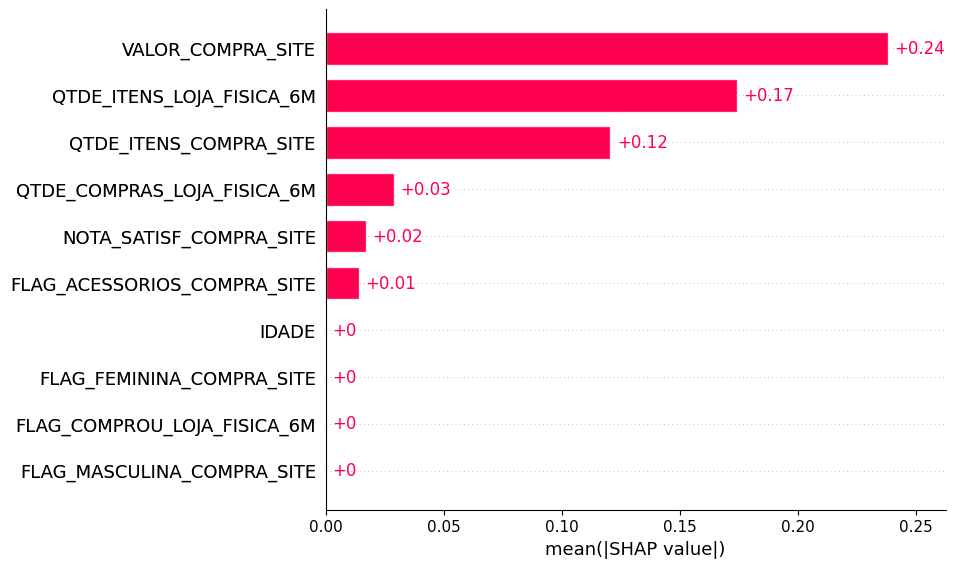

In [ ]:
# Gráfico do SHAP absoluto médio por feature
shap.plots.bar(valores_shap)

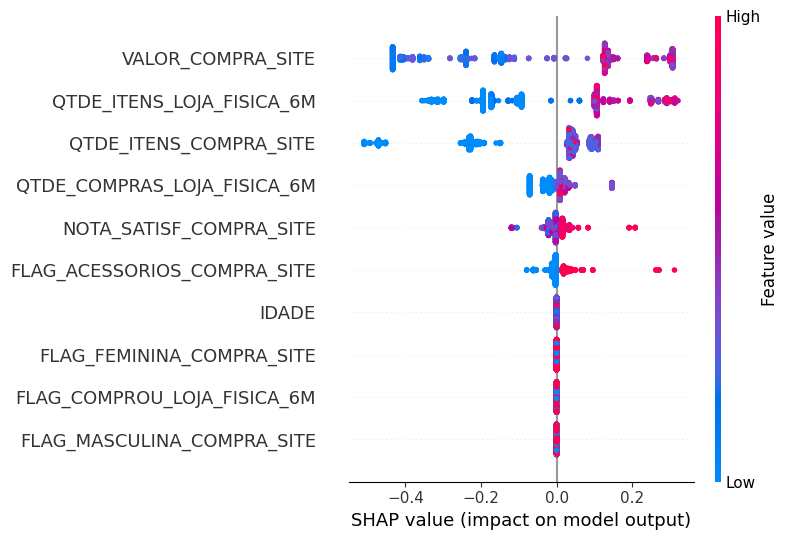

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
shap.summary_plot(valores_shap)